<a href="https://colab.research.google.com/github/Das0412/personal-portfolio/blob/main/tealeaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tp
from tensorflow import keras
import numpy as np

In [11]:
dataset=tp.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/tealeaves/tea sickness dataset',
                                                            labels= 'inferred',
                                                            batch_size=32,
                                                            image_size=[256,256])

Found 887 files belonging to 8 classes.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.0 MB/s eta 0:00:00


In [13]:
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [15]:
class_names = dataset.class_names
class_names

['Anthracnose',
 'algal leaf',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

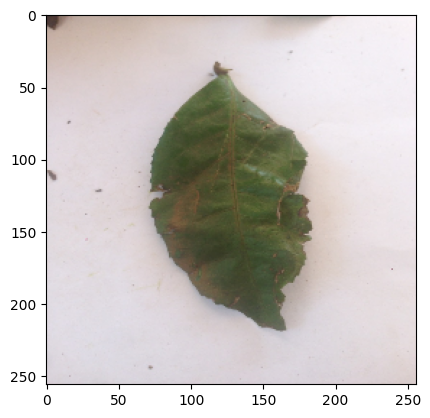

In [22]:
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))

In [25]:
len(dataset)


28

In [26]:
train_size = 0.8
len(dataset)*train_size

22.400000000000002

In [27]:
train_ds = dataset.take(22)
len(train_ds)

22

In [28]:
test_ds =dataset.skip(22)
len(test_ds)

6

In [30]:
val_size =0.1
len(dataset)*val_size

2.8000000000000003

In [32]:
val_size = test_ds.take(2)
len(val_size)

2

In [34]:
test_ds =test_ds.skip(2)
len(test_ds)

0

In [35]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [36]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

22

In [38]:
len(val_ds)

2

In [39]:
len(test_ds)

4

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tp.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tp.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tp.data.AUTOTUNE)

In [47]:
resize_and_rescale = tp.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [48]:
data_augmentation = tp.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [50]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tp.data.AUTOTUNE)

In [59]:
input_shape = (32, 256, 256, 3)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [60]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, None)    0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [61]:
model.compile(
    optimizer='adam',
    loss=tp.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [62]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
22/22 [==============================] - 10s 277ms/step - loss: 1.9949 - accuracy: 0.2101 - val_loss: 1.8005 - val_accuracy: 0.1719
Epoch 2/50
22/22 [==============================] - 6s 287ms/step - loss: 1.5198 - accuracy: 0.2734 - val_loss: 1.2796 - val_accuracy: 0.3906
Epoch 3/50
22/22 [==============================] - 6s 260ms/step - loss: 1.3177 - accuracy: 0.3957 - val_loss: 1.1650 - val_accuracy: 0.4688
Epoch 4/50
22/22 [==============================] - 7s 319ms/step - loss: 1.2174 - accuracy: 0.4072 - val_loss: 1.1109 - val_accuracy: 0.4531
Epoch 5/50
22/22 [==============================] - 6s 280ms/step - loss: 1.0858 - accuracy: 0.4576 - val_loss: 1.0649 - val_accuracy: 0.4375
Epoch 6/50
22/22 [==============================] - 7s 297ms/step - loss: 1.0837 - accuracy: 0.4590 - val_loss: 1.0524 - val_accuracy: 0.5312
Epoch 7/50
22/22 [==============================] - 6s 271ms/step - loss: 1.0687 - accuracy: 0.4763 - val_loss: 1.4817 - val_accuracy: 0.4062
Epoch

In [63]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 27s 30ms/step - loss: 0.6195 - accuracy: 0.7969


In [64]:
history

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

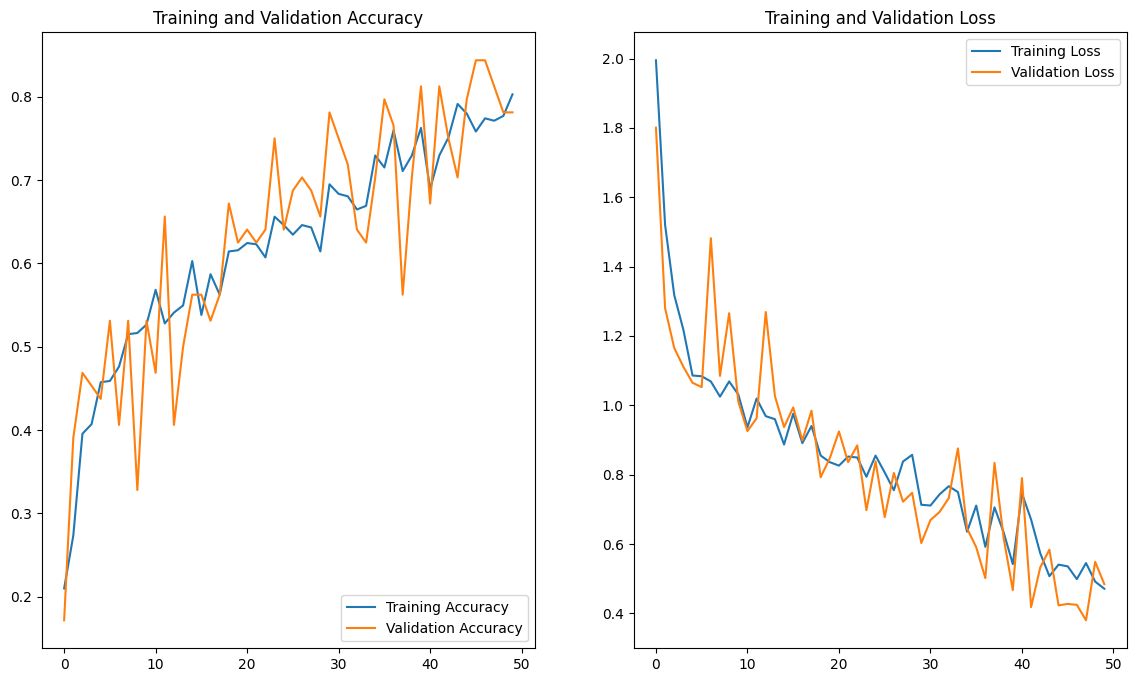

In [70]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()